In [2]:
# [timestamp, GPS [latitude, longitude], GYRO [x, y, z], ACC [x, y, z], BMP Altitude]
telem = []

with open("telem.csv", "r") as f:

    while True:
        line = f.readline().strip()

        if line == "":
            break

        data = [0, [0, 0], [0, 0, 0], [0, 0, 0], 0]
        if not "GPS" in line:
            continue
        line = line.split(";")

        for section in line:
            if "GPS" in section:
                section = section.split(",")
                data[0] = float(section[0][4:])
                if (section[1] == "A"):
                    if section[3] == "S":
                        data[1][0] = float("-" + section[2][:2] + "." + str(float(section[2][2:]) / 60)[2:8])
                    else:
                        data[1][0] = float(section[2][:2] + "." + str(float(section[2][2:]) / 60)[2:8])

                    if section[5] == "W":
                        data[1][1] = float("-" + section[4][:3] + "." + str(float(section[4][3:]) / 60)[2:8])
                    else:
                        data[1][1] = float(section[4][:3] + "." + str(float(section[4][3:]) / 60)[2:8])

            if "GYRO" in section:
                section = section.split(",")
                data[2][0] = float(section[0][5:])
                data[2][1] = float(section[1])
                data[2][2] = float(section[2])

            if "ACC" in section:
                section = section.split(",")
                data[3][0] = float(section[0][4:])
                data[3][1] = float(section[1])
                data[3][2] = float(section[2])

            if "BMP" in section:
                section = section.split(",")
                data[4] = float(section[2])

        telem.append(data)


array([   11.96140288,    11.96140288,    11.96140288, ...,
       -1468.81650094, -1468.81650094, -1468.81650094])

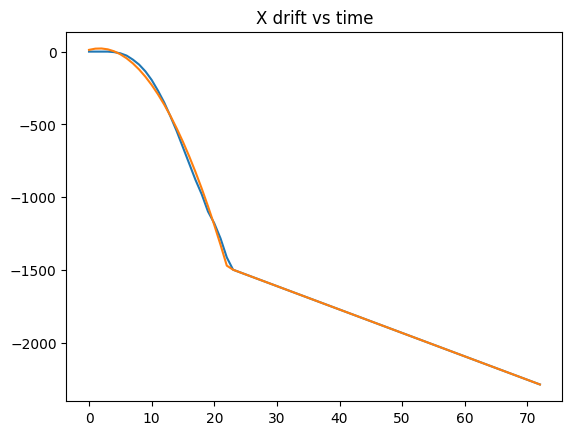

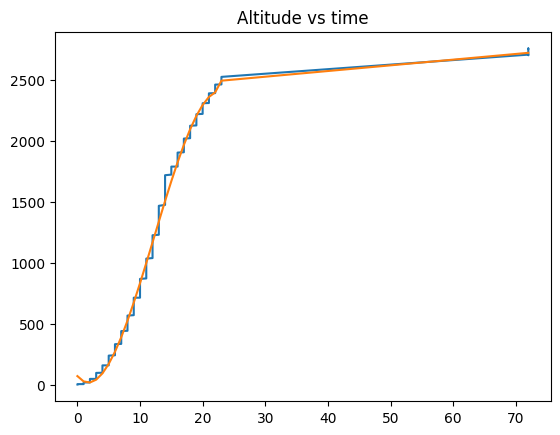

In [3]:
from math import cos, sqrt, radians
import matplotlib.pyplot as plt
import numpy as np

def get_positions(telemetry_data):
    '''
    Return ENU coordinates centered on the first telemetry datapoint
    '''
    EARTH_RADIUS = 6_378_000
    initial_lat, initial_lng = telemetry_data[0][1]
    initial_alt = telemetry_data[0][-1]
    initial_timestamp = telemetry_data[0][0]
    positions = []
    for timestamp, (lat,lng), (gyro_x,gyro_y,gyro_z), (acc_x,acc_y,acc_z), alt in telemetry_data:
        if abs(alt-initial_alt)<1:
            continue

        d_lat =  radians(lat-initial_lat)
        d_lng = radians(lng-initial_lng)
        if abs(d_lat)>1 or abs(d_lng)>1:
            continue
        d_alt = alt-initial_alt
        d_time = timestamp-initial_timestamp
        x_est = d_lng*EARTH_RADIUS
        y_est = d_lat*EARTH_RADIUS
        positions.append([d_time, x_est, y_est, d_alt])
    return positions

def eval_cubic(coefficients, t):
    a,b,c,d = coefficients
    return a*t**3 + b*t**2 + c*t + d

def eval_quadratic(coefficients, t):
    a,b,c = coefficients
    return a*t**2+b*t+c

def eval_linear(coefficients, t):
    a,b = coefficients
    return a*t+b

engine_cutoff_time = 23 
positions = np.array(get_positions(telem))
positions[:,0]-=positions[0,0]

pre_cutoff = positions[positions[:,0]<engine_cutoff_time]
x_coeff_1 = np.polyfit(pre_cutoff[:,0], pre_cutoff[:,1],2)
y_coeff_1 = np.polyfit(pre_cutoff[:,0], pre_cutoff[:,2],2)
z_coeff_1 = np.polyfit(pre_cutoff[:,0], pre_cutoff[:,3],3)
post_cutoff = positions[positions[:,0]>=engine_cutoff_time]
x_coeff_2 = np.polyfit(post_cutoff[:,0], post_cutoff[:,1],1)
y_coeff_2 = np.polyfit(post_cutoff[:,0], post_cutoff[:,2],1)
z_coeff_2 = np.polyfit(post_cutoff[:,0], post_cutoff[:,3],1)

times_pre_cutoff = pre_cutoff[:,0]
times_post_cutoff = post_cutoff[:,0]

times = positions[:,0]
xs = positions[:,1]
ys = positions[:,2]
zs = positions[:,3]
plt.figure()
plt.title("X drift vs time")
plt.plot(times, xs)
plt.plot(
    times, 
    np.concatenate([eval_quadratic(x_coeff_1,times_pre_cutoff),eval_linear(x_coeff_2, times_post_cutoff)],axis=0)
)

# plt.figure()
# plt.title("Y drift vs time")
# plt.plot(times, ys)
# plt.plot(
#     times, 
#     eval_quadratic(y_coeff_1,times)
# )

plt.figure()
plt.title("Altitude vs time")
plt.plot(times, zs)
plt.plot(
    times, 
    np.concatenate([eval_cubic(z_coeff_1,times_pre_cutoff),eval_linear(z_coeff_2, times_post_cutoff)],axis=0)
)

# plt.figure()
# plt.title("Altitude vs total horizontal drift")
# plt.plot(zs, [sqrt(x**2+y**2) for x,y in zip(xs,ys)])
eval_quadratic(x_coeff_1,times_pre_cutoff)

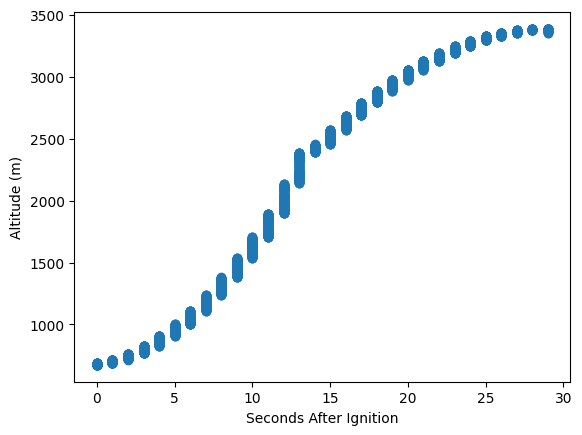

In [4]:
import numpy as np
import matplotlib.pyplot as plt

alt = np.array([[data[0] - 231729, data[4]] for data in telem[3320:6500]])

%matplotlib inline

plt.scatter(alt[:,0], alt[:,1])
plt.xlabel("Seconds After Ignition")
plt.ylabel("Altitude (m)")
plt.show()

12.081300054997694


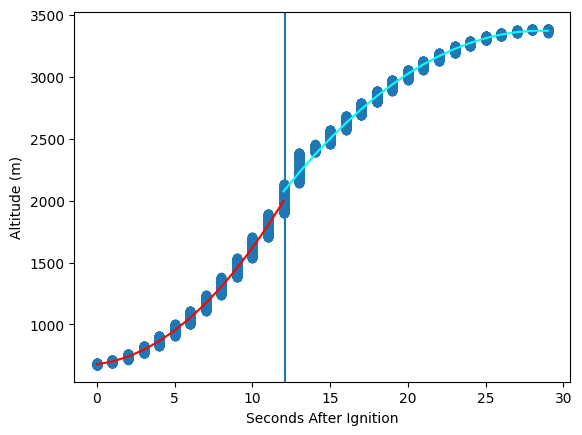

In [8]:
# 3rd order polynomial best fit line
a, b, c, d = np.polyfit(alt[:,0], alt[:,1], 3)

# inflection point
thrusttime = - b / (3 * a)
thrustinde_s = np.where(alt == int(thrusttime))[0][0]
thrustinde_e = np.where(alt == int(thrusttime))[0][-1]

plt.scatter(alt[:,0], alt[:,1])
plt.axvline(thrusttime)
print(thrusttime)

# thrust, 3rd order polynomial best fit
thrustlinefit = np.polyfit(alt[:thrustinde_e][:,0], alt[:thrustinde_e][:,1], 3)
plt.plot(alt[:thrustinde_e][:,0], thrustlinefit[0] * alt[:thrustinde_e][:,0]**3 + thrustlinefit[1] * alt[:thrustinde_e][:,0]**2 + thrustlinefit[2] * alt[:thrustinde_e][:,0] + thrustlinefit[3], color = "red")

# free fall, 2nd order polynomial best fit
falllinefit = np.polyfit(alt[thrustinde_s:][:,0], alt[thrustinde_s:][:,1], 2)
plt.plot(alt[thrustinde_s:][:,0], falllinefit[0] * alt[thrustinde_s:][:,0]**2 + falllinefit[1] * alt[thrustinde_s:][:,0] + falllinefit[2], color = "cyan")

plt.xlabel("Seconds After Ignition")
plt.ylabel("Altitude (m)")
plt.show()

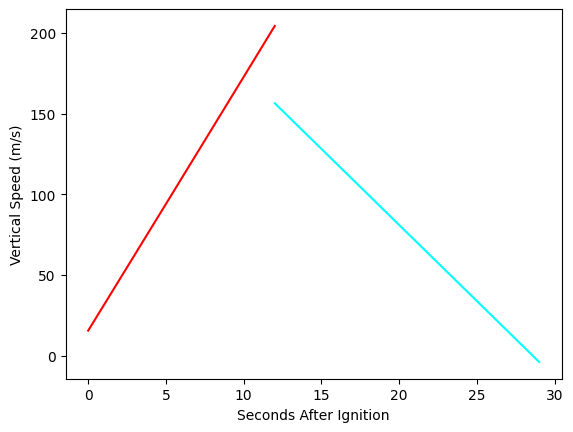

In [6]:
plt.plot(alt[:thrustinde_e][:,0], 3 * thrustlinefit[0] * alt[:thrustinde_e][:,0]**2 + 2 * thrustlinefit[1] * alt[:thrustinde_e][:,0] + thrustlinefit[2], color = "red")
plt.plot(alt[thrustinde_s:][:,0], 2 * falllinefit[0] * alt[thrustinde_s:][:,0] + falllinefit[1], color = "cyan")
plt.xlabel("Seconds After Ignition")
plt.ylabel("Vertical Speed (m/s)")
plt.show()

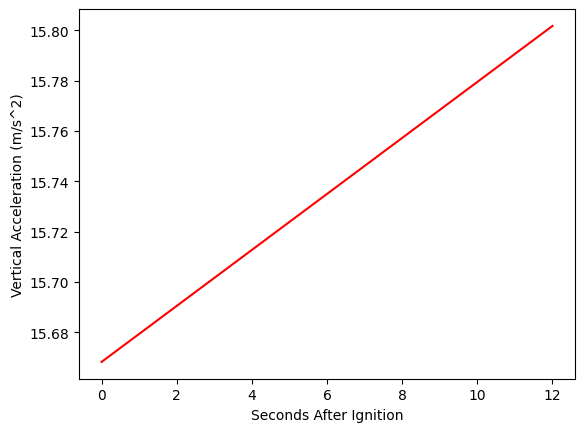

In [7]:
plt.plot(alt[:thrustinde_e][:,0], 6 * thrustlinefit[0] * alt[:thrustinde_e][:,0] + 2 * thrustlinefit[1], color = "red")
plt.xlabel("Seconds After Ignition")
plt.ylabel("Vertical Acceleration (m/s^2)")
plt.show()